[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/036_rnn_mejoras/rnn_mejoras.ipynb)

# Mejorando las Redes Recurrentes

En posts anteriores hemos aprendido sobre `redes neuronales recurrentes` y cómo podemos aplicarlas para tareas con datos secuenciales, como por ejemplo predicción de series temporales. El tipo de redes recurrentes que hemos visto nos han sido útiles para resolver los casos sencillos que hemos visto, pero tienen problemas para trabajar con secuencias muy largas (varios centenares de instantes temporales). Para ello, ciertas mejoras se han desarrollado que alivian este problema. En este post vamos a hablar de algunas de estas mejores que puedes aplicar a tus problemas en caso que tus redes recurrentes simples no funcionen bien.

In [9]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [7]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [11]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

def predict(model, dataloader):
    model.eval() 
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

## La Celda Recurrente

Si revisamos la forma en la que nuestra `red recurrente` funciona, recordamos que tenemos una serie de entradas (las cuales multiplicaremos por su matriz de pesos) y también tenemos conexiones a los valores de la capa oculta en el instante anterior (las cuales también multiplicamos por su matriz de pesos). Sumamos ambas cantidades, le aplicamos la función de activación (que en el caso de las redes recurrentes suele usarse la función `tanh`) y el resultado lo pasamos a la siguiente capa. Estas operaciones son llevadas a cabo por la `celda recurrente` y podemos ilustrarla como en la siguiente figura

![](https://sensioai.com/blog/036/cell.png)

Esta es la `celda recurrente` implementada en la calse `torch.nn.RNN` en `Pytorch`, la que hemos usado en los posts anteriores. En el siguiente ejemplo la utilizamos para la predicción de series temporales.

In [16]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [17]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.03683 loss_last_step 0.02208 val_loss 0.03707 val_loss_last_step 0.02465: 100%|█| 10/1


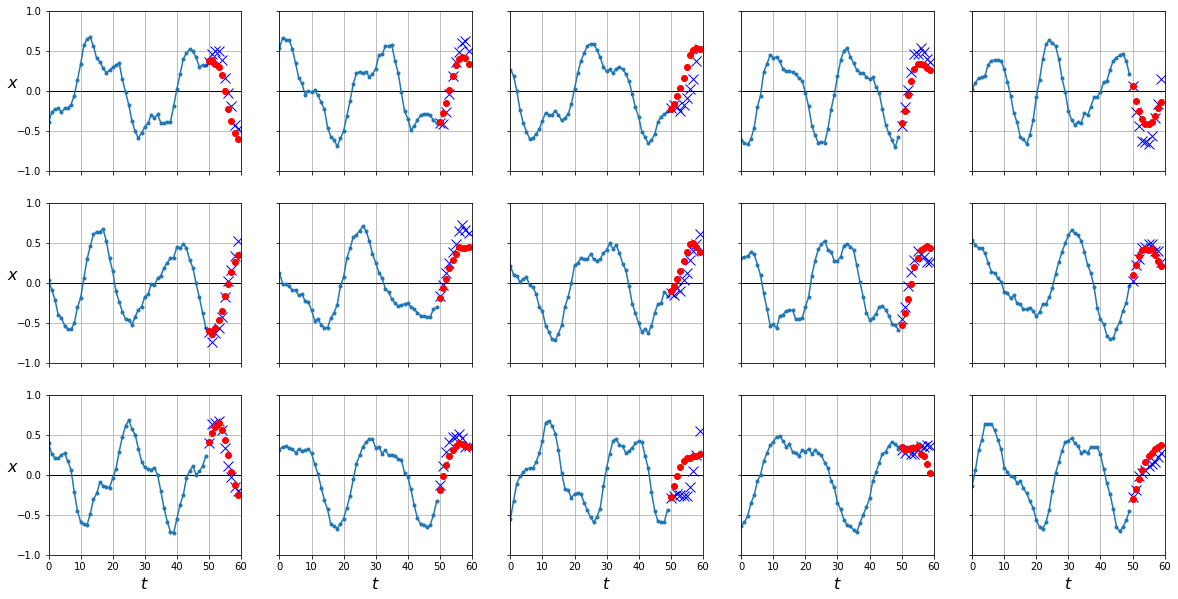

0.023463089

In [18]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

El principal problema de esta formulación es que no es capaz de mantener dependencias a largo plazo. De la manera en la que funciona el algoritmo de *backpropagation* si los pesos de la red toman valores altos, al ir multiplicando los gradientes por estos pesos, éstos empiezan a crecer imposibilitando el entrenamiento. A este problema se le conoce como *exploding gradient*, y puede aliviarse limitando el valor máximo de los gradientes en lo que se conoce como *gradient clipping*. En el caso contrario, en que los pesos sean pequeños, los gradientes irán disminuyendo hasta desaparecer en los que se conoce como *vanishing gradients*. Cuando este fenómeno ocurre, la influencia que tienen los primeros instantes temporales en las última salidas son inexistentes, dañando el desempeño de nuestras redes recurrentes. Para solventar este problema se han diseñado `celdas recurrentes` alternativas, veamos dos ejemplos. 

## *Long Short-Term Memmory* (LSTM)

![](https://upload.wikimedia.org/wikipedia/commons/9/98/LSTM.png)

Como puedes ver, la celda `LSTM` es bastante diferente a la `celda recurrente` básica. Sus principales características son: el uso de dos conjuntos de valores en las capas ocultas, $h$ y $c$, y el uso de diferentes puertas (o *gates* en inglés) que controlan el flujo de información en la celda.

En la celda `LSTM` seguimos multiplicando los inputs $x$ y los valores en la capa oculta $h$ por sus respectivas matrices de pesos. La diferencia es que ahora tenemos diferentes matrices de pesos para cada una de las puertas. Tras calcular los productos y sumar los resultados, $\mathbf{W}_{xi} \mathbf{x} + \mathbf{W}_{hi} \mathbf{h}$,  aplicamos la función de activación `sigmoid` para controlar el flujo de información en las puertas *forget*, *input* y *output* de izquierda a derecha en la imagen anterior respectivamente. La puerta *forget* controla cuanta información en el camino *long term*, $c$, debe olvidar la celda. La puerta *input* controla cuanta información nueva añadimos al camino *long term*. Date cuenta que la nueva información que añadimos es exactamente igual a la salida de la celda recurrente simple. Por último, la puerta *output* controla cuanta información pasar a la siguiente celda por el camino *short term*, $h$.

Entender el funcionamiento de una celda `LSTM` no es sencillo y requiere invertir un tiempo en entender todo lo que está ocurriendo dentro. Gracias al camino *long term* los gradientes pueden fluir por la `red recurrente` de manera limpia, aliviando el problema explicado anteriormente con la celda recurrente simple. En `Pytorch`, simplemente tenemos que cambiar nuestra capa `torch.nn.RNN` por `torch.nn.LSTM`.

In [22]:
class LSTM(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
    
lstm = LSTM()

In [30]:
# parámetros en inputs (W_ii|W_if|W_ig|W_io)
# 4 matrices, 1 para cada *gate* 

lstm.rnn.weight_ih_l0.shape, lstm.rnn.bias_ih_l0.shape

(torch.Size([80, 1]), torch.Size([80]))

In [31]:
# parámetros en capa oculta (W_ii|W_if|W_ig|W_io)
# 4 matrices, 1 para cada *gate* 

lstm.rnn.weight_hh_l0.shape, lstm.rnn.bias_hh_l0.shape

(torch.Size([80, 20]), torch.Size([80]))

In [42]:
# salida y capas ocultas (short term y long term)

output, (h, c) = lstm.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape, c.shape

(torch.Size([2, 10, 20]), torch.Size([2, 10, 20]))

In [52]:
lstm = LSTM()
fit(lstm, dataloader)

loss 0.02818 loss_last_step 0.01200 val_loss 0.02806 val_loss_last_step 0.01143: 100%|█| 10/1


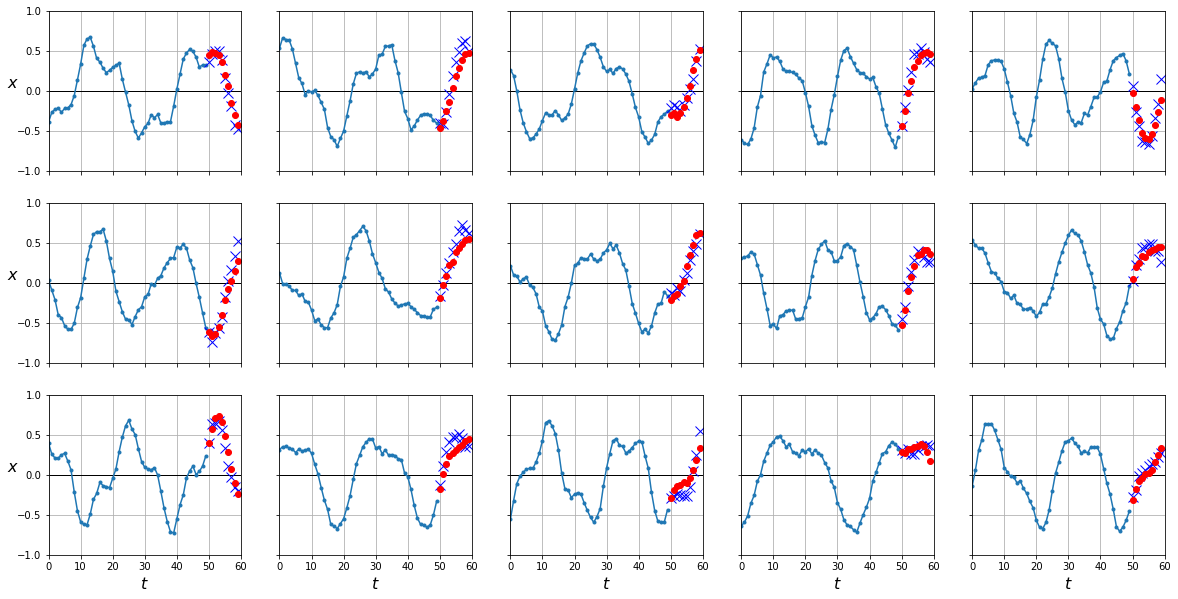

0.011731032

In [53]:
y_pred = predict(lstm, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

Como puedes ver, al ser capaces de mantener relaciones de más larga distancia nuestra red `LSTM` nos da mejores resultados en las predicciones. Estos resultados son más evidentes en el caso de secuencias de mayor longitud (como veremos en futuros posts).

## *Gated Recurrent Unit* (GRU)

![](https://feature.engineering/content/images/2016/03/gru.png)

Inspirado en la celda `LSTM`, la celda `GRU` intenta solventar también el mismo problema pero con menos parámetros y con un solo un conjunto de valores en la capa oculta, como en la formulación original de la celda recurrente. De nuevo, en `Pytorch` simplemente tenemos que usar la capa `torch.nn.GRU`.

In [47]:
class GRU(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.GRU(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
    
gru = GRU()

In [48]:
# parámetros en inputs (W_ir|W_iz|W_in)
# 3 matrices, 1 para cada *gate* 

gru.rnn.weight_ih_l0.shape, lstm.rnn.bias_ih_l0.shape

(torch.Size([60, 1]), torch.Size([80]))

In [49]:
# parámetros en capa oculta (W_hr|W_hz|W_hn)
# 3 matrices, 1 para cada *gate* 

gru.rnn.weight_hh_l0.shape, lstm.rnn.bias_hh_l0.shape

(torch.Size([60, 20]), torch.Size([80]))

In [51]:
# salida y capas ocultas (short term y long term)

output, h = gru.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape

torch.Size([2, 10, 20])

In [54]:
gru = GRU()
fit(gru, dataloader)

loss 0.03235 loss_last_step 0.02132 val_loss 0.03123 val_loss_last_step 0.01865: 100%|█| 10/1


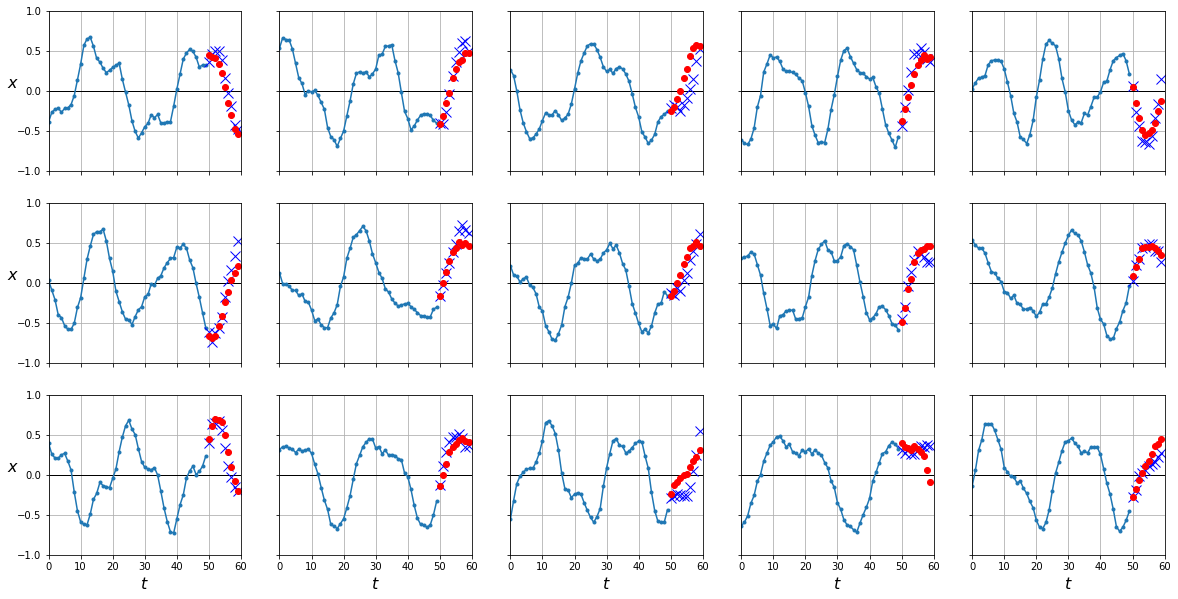

0.017855287

In [55]:
y_pred = predict(gru, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

## Redes Recurrentes Bidireccionales

Otra posible solución que puede mejorar los resultados de una `red recurrente` en secuencias largas es el uso de `redes bidireccionales`.

![](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

En esta arquitectura, básicamente mantenemos dos redes recurrentes a la vez. A una la alimentamos con nuestras secuencias de manera normal mientras que a la segunda le damos los datos al revés, empezando por el final. En cada instante combinaremos los resultados en una única salida. Esta arquitectura, sin embargo, sólo podemos aplicarlo en casos en los que podamos "mirar al futuro" para realizar la tarea concreta. Éste no es el caso de la predicción de series temporales, ya que el objetivo es precisamente predecir el futuro, pero sí que podemos utilizar redes bidireccionales en tareas de clasificación de texto o traducción entre varias lenguas. Podemos indicarle a `Pytorch` que queremos que nuestras capas recurrentes sean bidireccionales con el parámetro `bidirectional`.

In [58]:
class BidirectionalRNN(DeepRNN):
    def __init__(self, n_out=10, dropout=0, bidirectional=False):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        if bidirectional:
            self.fc = torch.nn.Linear(2*hidden_dim, output_dim)

De la misma manera puedes cambiar la capa por `torch.nn.LSTM` o `torch.nn.GRU` para tener una red recurrente bidireccional con este tipo de red.

## Resumen

En este post hemos presentado diferentes mejoras que podemos aplicar a nuestras `redes recurrentes` para obtener mejores resultados cuando trabajemos con secuencias largas. Hemos revisado el modelo matemático de la `celda recurrente` simple utilizado como base por celdas más sofisticadas como la `LSTM` o `GRU`, las cuales añaden caminos adicionales y/o puertas que controlan el flujo de información. Estas mejoras proveen de mejores caminos para la propagación de los gradientes desde las últimas salidas hasta las primeras entradas. También hemos introducido las redes recurrentes bidireccionales, que usaremos en casos en los que podamos utilizar toda la secuencia para la tarea en concreto. 